In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from stfe.gene_utils import get_markers
import scanpy as sc
from plotly3d.plot import trajectories
from sklearn.cluster import KMeans
import pandas as pd
import pathlib
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# TODO: use apoptotic trajectories for Supplementary figure!

In [2]:
output_dir = '../results_Jun2_suppl/'
pathlib.Path(output_dir).mkdir(exist_ok=True)

adata = sc.read_h5ad('../data/rna_figure_ready.h5ad')
gene_names = adata.var_names.to_numpy()

# TODO!!! USE GRnager for Apopt traj!!
draft_matrix = pd.read_csv('../data/new_all_pval.csv', index_col=0)

alex_genes = [c.strip('_y') for c in draft_matrix.columns]
alex_tfs = [c.strip('_x') for c in draft_matrix.index]

traj = np.load(f"../results_final_Dec22/traj_gene_space_A_extreme.npy", allow_pickle=True)

alex_gene_all = list(set(alex_genes) | set(alex_tfs))
alex_gene_all_mask = np.isin(adata.var_names, alex_gene_all)
traj = traj[:, :, alex_gene_all_mask]
gene_names = adata.var_names[alex_gene_all_mask]

traj_mean = traj.mean(axis=1)
traj_std = traj.std(axis=1)
traj_mean_std = traj_mean.std(axis=0)
zero_std_genes = traj_mean_std == 0
gene_names = np.array(gene_names)[~zero_std_genes]
traj, traj_mean, traj_std, traj_mean_std = traj[..., ~zero_std_genes], traj_mean[..., ~zero_std_genes], traj_std[..., ~zero_std_genes], traj_mean_std[..., ~zero_std_genes]
# traj_mean_normalized = (traj_mean - traj_mean.mean(axis=0)) / traj_mean.std(axis=0)
traj_mean_normalized = (traj_mean - traj_mean.min(axis=0)) / (traj_mean.max(axis=0) - traj_mean.min(axis=0))

trends_df = pd.DataFrame(traj_mean_normalized, columns=gene_names, index=[f't{i}' for i in range(traj_mean_normalized.shape[0])]).T
# Get the indices of top 5 values for each row
top_5_indices = trends_df.apply(lambda x: np.where(x >= sorted(x)[-1])[0].mean(), axis=1)
# Sort the dataframe by mean of top 5 indices
trends_df_sorted = trends_df.iloc[top_5_indices.argsort()]

trends_df_sorted_numerical_index = trends_df_sorted.reset_index(drop=True)

# Split indices into 5 groups using the cluster points
cluster_pts = [1270, 1740, 2100, 3567]
cluster_groups = [
    trends_df_sorted.index[:cluster_pts[0]].tolist(),
    trends_df_sorted.index[cluster_pts[0]:cluster_pts[1]].tolist(),
    trends_df_sorted.index[cluster_pts[1]:cluster_pts[2]].tolist(), 
    trends_df_sorted.index[cluster_pts[2]:cluster_pts[3]].tolist(),
    trends_df_sorted.index[cluster_pts[3]:].tolist()
]

cluster_df = pd.DataFrame(np.arange(len(trends_df_sorted.index)), index=trends_df_sorted.index, columns=['number'])
cluster_df['cluster'] = np.nan
for i, cluster_group in enumerate(cluster_groups):
    cluster_df.loc[cluster_group, 'cluster'] = i



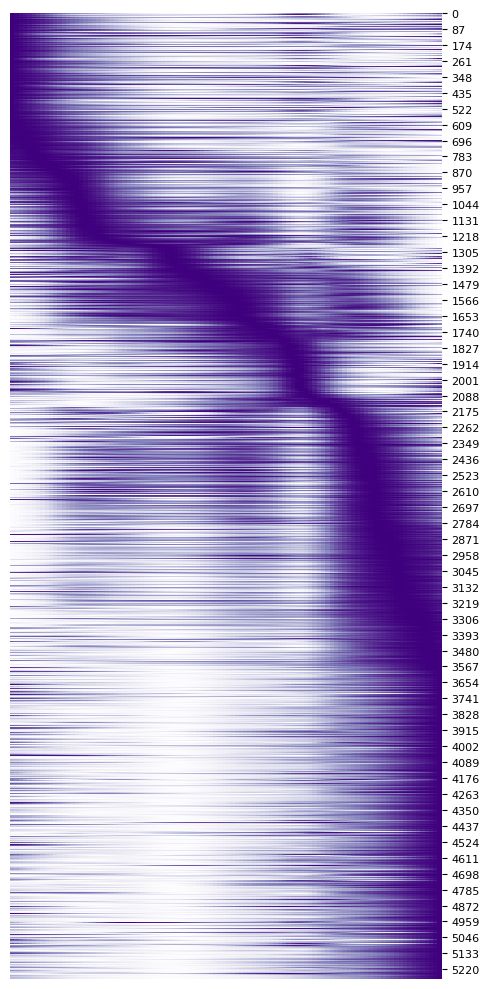

In [3]:
# Create a figure with a specific size
fig = plt.figure(figsize=(5, 10))

# Create a simple heatmap without clusters
ax_heatmap = plt.subplot(111)
sns.heatmap(trends_df_sorted, cmap='Purples', vmin=0, vmax=1,
            cbar=False, ax=ax_heatmap, yticklabels=False, xticklabels=False)

# Set y-ticks to show numerical positions with appropriate spacing
ax_heatmap.yaxis.set_label_position("right")
ax_heatmap.yaxis.tick_right()

# Set numerical y-tick positions and labels
num_genes = len(trends_df_sorted)
tick_spacing = max(1, num_genes // 60)  # Show approximately 20 ticks
ytick_positions = range(0, num_genes, tick_spacing)
ytick_labels = [str(i) for i in ytick_positions]
ax_heatmap.set_yticks(ytick_positions)
ax_heatmap.set_yticklabels(ytick_labels, fontsize=8)

# Remove x-ticks
ax_heatmap.set_xticks([])

plt.tight_layout()

# Save the heatmap
# plt.savefig(f'{output_dir}/gene_heatmap_with_indices.pdf', bbox_inches='tight', pad_inches=0.1, dpi=300)

/tmp/ipykernel_3733735/2919572467.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


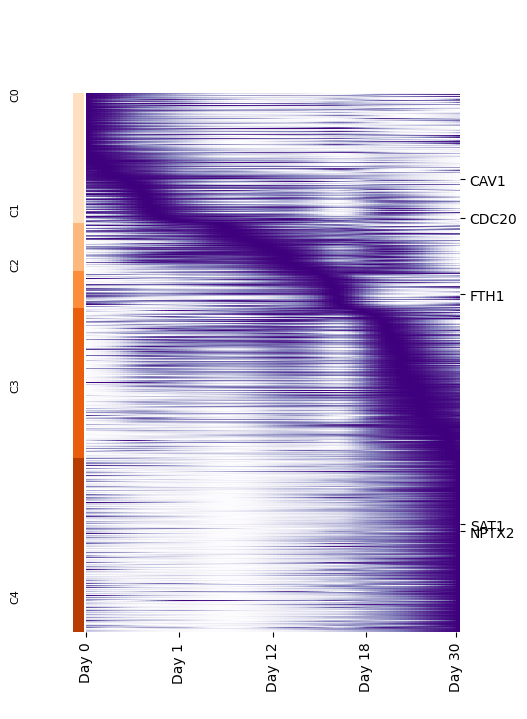

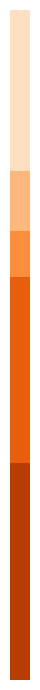

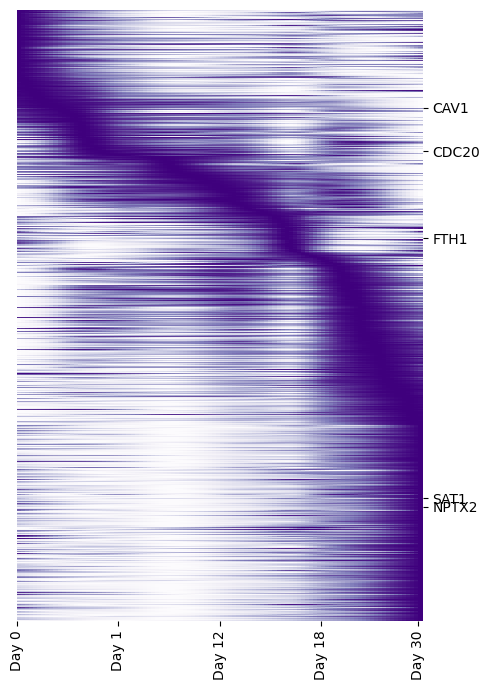

In [4]:
# Create a figure with a specific size
fig = plt.figure(figsize=(5, 7))

# Import gridspec from matplotlib
from matplotlib import gridspec
from matplotlib import colors as mcolors

# Create a color palette for the clusters using oranges
cluster_colors = sns.color_palette("Oranges", n_colors=len(cluster_groups))

# Create a gridspec to position the heatmap and color bar - make them closer together
gs = gridspec.GridSpec(1, 2, width_ratios=[0.03, 0.97], wspace=0.01)

# Add an axis for the cluster colors
ax_colors = plt.subplot(gs[0])
# Create a DataFrame with cluster colors as strings instead of tuples
color_map = {i: f'C{i}' for i in range(len(cluster_groups))}
cluster_color_values = cluster_df['cluster'].map(lambda x: color_map[int(x)])
cluster_df_colors = pd.DataFrame({'Cluster': cluster_color_values})

# Create a custom colormap for the clusters using oranges
cluster_cmap = mcolors.ListedColormap([cluster_colors[i] for i in range(len(cluster_groups))])
# Plot the cluster indicators without labels
sns.heatmap(pd.DataFrame(cluster_df['cluster']), cmap=cluster_cmap, 
            cbar=False, ax=ax_colors, yticklabels=False, xticklabels=False)

# Add the main heatmap with purple colormap
ax_heatmap = plt.subplot(gs[1])
sns.heatmap(trends_df_sorted, cmap='Purples', vmin=0, vmax=1,
            cbar=False, ax=ax_heatmap, yticklabels=False)

# Select genes to display on the y-axis
# ytick_genes = ['CD44', 'CAV1', 'EPCAM', 'TWIST1', 'TWIST2', 'SNAI1', 'SNAI2', 'ZEB1', 'ZEB2']
ytick_genes = ['CAV1', 'CDC20', 'FTH1', 'SAT1', 'NPTX2']
ytick_positions = [trends_df_sorted.index.get_loc(gene) for gene in ytick_genes if gene in trends_df_sorted.index]
ytick_labels = [ytick_genes[i] for i, pos in enumerate(ytick_positions)]

# Move y-axis to the right and set ticks
ax_heatmap.yaxis.set_label_position("right")
ax_heatmap.yaxis.tick_right()
ax_heatmap.set_yticks(ytick_positions)
ax_heatmap.set_yticklabels(ytick_labels, fontsize=10)

# Customize x-ticks to show days
days = [0, 1, 12, 18, 30]
tick_positions = [0, 25, 50, 75, 99]  # Evenly spaced positions
ax_heatmap.set_xticks(tick_positions)
ax_heatmap.set_xticklabels([f'Day {d}' for d in days], fontsize=10)

# Add cluster labels to the left
ax_cluster_labels = fig.add_axes([0, 0, 0.02, 1])  # Adjust position as needed
ax_cluster_labels.set_axis_off()

# Add cluster labels
for i, cluster_group in enumerate(cluster_groups):
    # Find the middle position of each cluster
    start_pos = trends_df_sorted.index.get_loc(cluster_group[0])
    end_pos = trends_df_sorted.index.get_loc(cluster_group[-1])
    mid_position = (start_pos + end_pos) / (2 * len(trends_df_sorted))
    
    # Add text label
    ax_cluster_labels.text(
        0.5, 1 - mid_position, f'C{i}', 
        ha='center', va='center', rotation=90,
        transform=ax_cluster_labels.transAxes, fontsize=8
    )

plt.tight_layout()
# plt.savefig(f'{output_dir}/gene_heatmap_cluster.pdf', bbox_inches='tight', pad_inches=0.1, dpi=300)

# Save the combined figure
plt.savefig(f'{output_dir}/gene_heatmap_cluster_combined.pdf', bbox_inches='tight', pad_inches=0.1, dpi=300)

# Create and save the cluster strip separately - without any labels
fig_strip = plt.figure(figsize=(0.5, 7))
ax_strip = plt.subplot(111)
sns.heatmap(pd.DataFrame(cluster_df['cluster']), cmap=cluster_cmap, 
            cbar=False, ax=ax_strip, yticklabels=False, xticklabels=False)
# No labels for the strip plot
plt.tight_layout()
plt.savefig(f'{output_dir}/gene_heatmap_cluster_strip.pdf', bbox_inches='tight', pad_inches=0.1, dpi=300)

# Create and save the heatmap separately
fig_heatmap = plt.figure(figsize=(5, 7))
ax_heatmap_only = plt.subplot(111)
sns.heatmap(trends_df_sorted, cmap='Purples', vmin=0, vmax=1,
            cbar=False, ax=ax_heatmap_only, yticklabels=False)
# Set the same y-ticks as the combined figure
ax_heatmap_only.yaxis.set_label_position("right")
ax_heatmap_only.yaxis.tick_right()
ax_heatmap_only.set_yticks(ytick_positions)
ax_heatmap_only.set_yticklabels(ytick_labels, fontsize=10)
# Set the same x-ticks as the combined figure
ax_heatmap_only.set_xticks(tick_positions)
ax_heatmap_only.set_xticklabels([f'Day {d}' for d in days], fontsize=10)
plt.tight_layout()
plt.savefig(f'{output_dir}/gene_heatmap_cluster_heatmap.pdf', bbox_inches='tight', pad_inches=0.1, dpi=300)

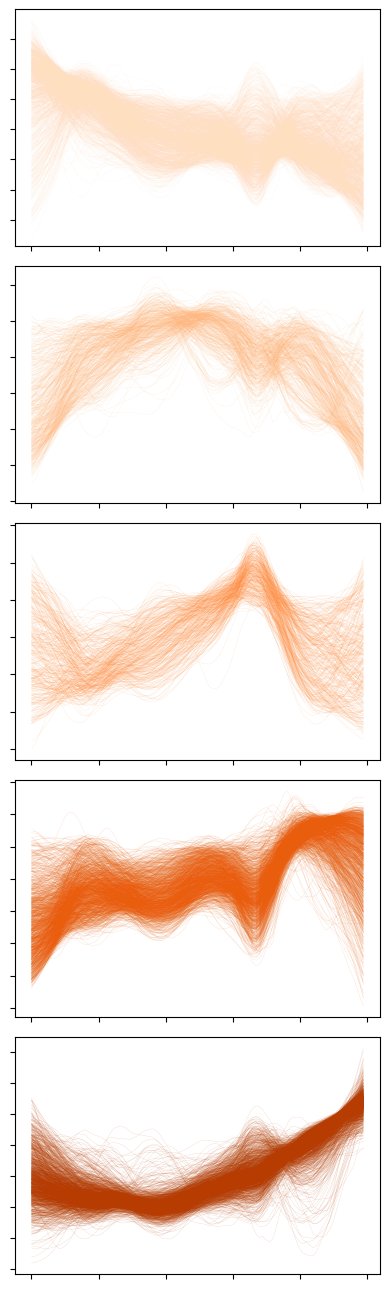

In [5]:
traj_mean_whiten = (traj_mean - traj_mean.mean(axis=0)) / traj_mean.std(axis=0)
trends_df_whiten = pd.DataFrame(traj_mean_whiten, columns=gene_names, index=[f't{i}' for i in range(traj_mean_whiten.shape[0])]).T

# Get the indices of top 5 values for each row
top_5_indices = trends_df_whiten.apply(lambda x: np.where(x >= sorted(x)[-10])[0].mean(), axis=1)
# Sort the dataframe by mean of top 5 indices
trends_df_whiten_sorted = trends_df_whiten.iloc[top_5_indices.argsort()]
trends_df_whiten_sorted

trends_df_whiten_sorted_numerical_index = trends_df_whiten_sorted.reset_index(drop=True)
# plt.figure(figsize=(5, 10))
# sns.heatmap(trends_df_whiten_sorted_numerical_index, cmap='inferno',
#                  )

# Use the same orange color palette as in the strip
cluster_colors = sns.color_palette("Oranges", n_colors=len(cluster_groups))

fig, axs = plt.subplots(5, 1, figsize=(4, 13))
for i, trend_subset in enumerate(cluster_groups):
    to_plot = trends_df_whiten_sorted.loc[trend_subset, :]
    # make plots using plt plot with the corresponding orange color from the palette
    for row in to_plot.iterrows():
        axs[i].plot(row[1].values, color=cluster_colors[i], linewidth=0.05, alpha=1.0)
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
plt.tight_layout()
# plt.savefig(f'{output_dir}/plot_cluster_extreme_T_whiten_draft.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

/tmp/ipykernel_3733735/1363299482.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)


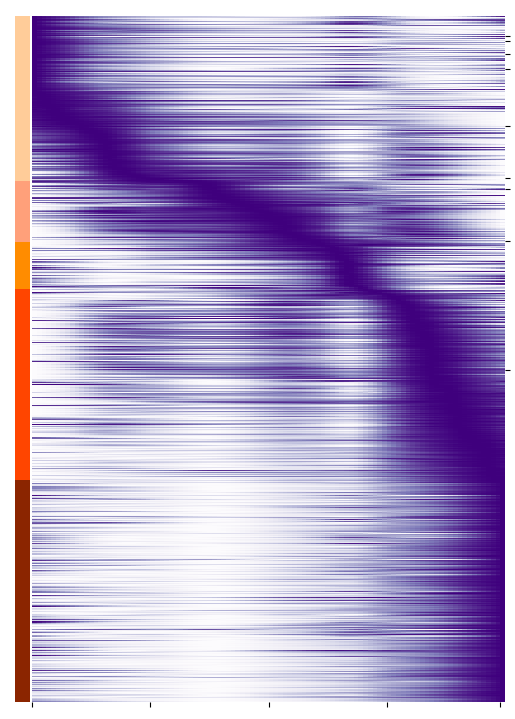

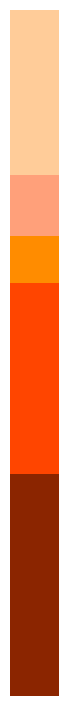

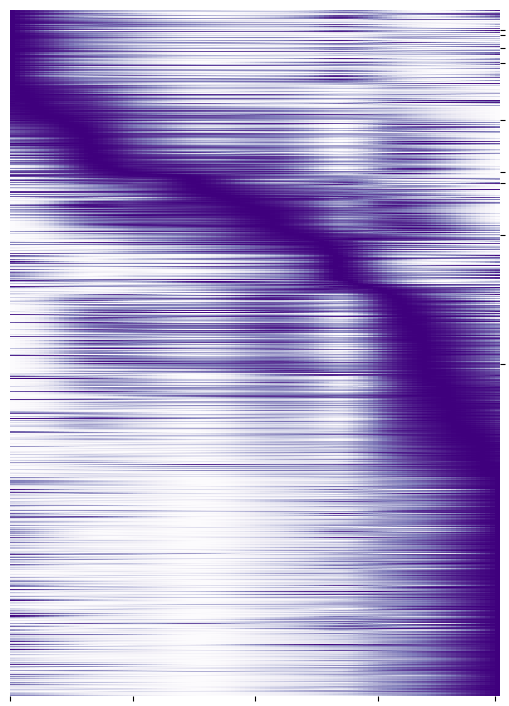

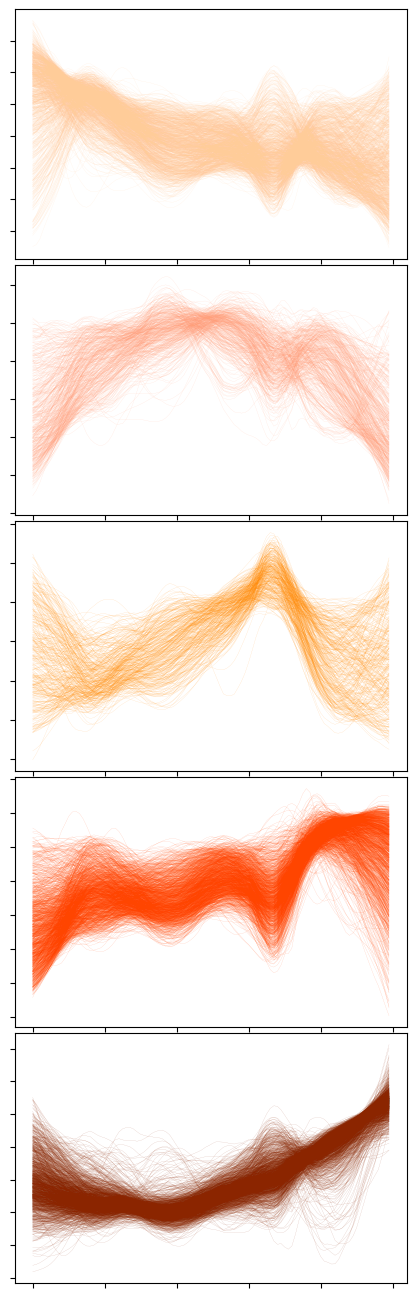

In [6]:
# Create a figure with a specific size
fig = plt.figure(figsize=(5, 7))

# Import gridspec from matplotlib
from matplotlib import gridspec
from matplotlib import colors as mcolors

# Create a more distinctive color palette for the clusters using darker oranges
# Use a custom list of darker orange colors that are more distinct from each other
custom_oranges = [
    "#FFCC99",  # Light Peach
    "#FFA07A",  # Light Salmon
    "#FF8C00",  # Dark Orange
    "#FF4500",  # Orange Red
    "#8B2500"   # Deep Burnt Orange
]
cluster_colors = custom_oranges[:len(cluster_groups)]

# Create a gridspec to position the heatmap and color bar - make them closer together
gs = gridspec.GridSpec(1, 2, width_ratios=[0.03, 0.97], wspace=0.01)

# Add an axis for the cluster colors
ax_colors = plt.subplot(gs[0])
# Create a DataFrame with cluster colors as strings instead of tuples
color_map = {i: f'C{i}' for i in range(len(cluster_groups))}
cluster_color_values = cluster_df['cluster'].map(lambda x: color_map[int(x)])
cluster_df_colors = pd.DataFrame({'Cluster': cluster_color_values})

# Create a custom colormap for the clusters using the distinctive oranges
cluster_cmap = mcolors.ListedColormap(cluster_colors)
# Plot the cluster indicators without labels
sns.heatmap(pd.DataFrame(cluster_df['cluster']), cmap=cluster_cmap, 
            cbar=False, ax=ax_colors, yticklabels=False, xticklabels=False)

# Add the main heatmap with purple colormap
ax_heatmap = plt.subplot(gs[1])
sns.heatmap(trends_df_sorted, cmap='Purples', vmin=0, vmax=1,
            cbar=False, ax=ax_heatmap, yticklabels=False)

# Select genes to display on the y-axis (keep positions but no labels)
ytick_genes = ['CD44', 'CAV1', 'EPCAM', 'TWIST1', 'TWIST2', 'SNAI1', 'SNAI2', 'ZEB1', 'ZEB2']
ytick_positions = [trends_df_sorted.index.get_loc(gene) for gene in ytick_genes if gene in trends_df_sorted.index]

# Move y-axis to the right and set ticks without labels
ax_heatmap.yaxis.set_label_position("right")
ax_heatmap.yaxis.tick_right()
ax_heatmap.set_yticks(ytick_positions)
ax_heatmap.set_yticklabels([""] * len(ytick_positions))  # Empty labels

# Customize x-ticks to show positions but no day labels
days = [0, 1, 12, 18, 30]
tick_positions = [0, 25, 50, 75, 99]  # Evenly spaced positions
ax_heatmap.set_xticks(tick_positions)
ax_heatmap.set_xticklabels([""] * len(tick_positions))  # Empty labels

# Add cluster labels to the left
ax_cluster_labels = fig.add_axes([0, 0, 0.02, 1])  # Adjust position as needed
ax_cluster_labels.set_axis_off()

# No cluster labels (removed text labels)
for i, cluster_group in enumerate(cluster_groups):
    # Keep the positions but don't add text
    pass

# Use tight layout with adjusted parameters to reduce margins
plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)

# Adjust the figure to remove excess margins
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)

# plt.savefig(f'{output_dir}/gene_heatmap_cluster.pdf', bbox_inches='tight', pad_inches=0.05, dpi=300)

# Save the combined figure
# plt.savefig(f'{output_dir}/gene_heatmap_cluster_combined.pdf', bbox_inches='tight', pad_inches=0.05, dpi=300)

# Create and save the cluster strip separately - without any labels
fig_strip = plt.figure(figsize=(0.5, 7))
ax_strip = plt.subplot(111)
sns.heatmap(pd.DataFrame(cluster_df['cluster']), cmap=cluster_cmap, 
            cbar=False, ax=ax_strip, yticklabels=False, xticklabels=False)
# No labels for the strip plot
plt.tight_layout(pad=0.1)
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
plt.savefig(f'{output_dir}/gene_heatmap_cluster_strip.pdf', bbox_inches='tight', pad_inches=0.05, dpi=300)

# Create and save the heatmap separately
fig_heatmap = plt.figure(figsize=(5, 7))
ax_heatmap_only = plt.subplot(111)
sns.heatmap(trends_df_sorted, cmap='Purples', vmin=0, vmax=1,
            cbar=False, ax=ax_heatmap_only, yticklabels=False)
# Set the same y-ticks as the combined figure but without labels
ax_heatmap_only.yaxis.set_label_position("right")
ax_heatmap_only.yaxis.tick_right()
ax_heatmap_only.set_yticks(ytick_positions)
ax_heatmap_only.set_yticklabels([""] * len(ytick_positions))  # Empty labels
# Set the same x-ticks as the combined figure but without labels
ax_heatmap_only.set_xticks(tick_positions)
ax_heatmap_only.set_xticklabels([""] * len(tick_positions))  # Empty labels
plt.tight_layout(pad=0.1)
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
plt.savefig(f'{output_dir}/gene_heatmap_cluster_heatmap.pdf', bbox_inches='tight', pad_inches=0.05, dpi=300)


traj_mean_whiten = (traj_mean - traj_mean.mean(axis=0)) / traj_mean.std(axis=0)
trends_df_whiten = pd.DataFrame(traj_mean_whiten, columns=gene_names, index=[f't{i}' for i in range(traj_mean_whiten.shape[0])]).T

# Get the indices of top 5 values for each row
top_5_indices = trends_df_whiten.apply(lambda x: np.where(x >= sorted(x)[-10])[0].mean(), axis=1)
# Sort the dataframe by mean of top 5 indices
trends_df_whiten_sorted = trends_df_whiten.iloc[top_5_indices.argsort()]
trends_df_whiten_sorted

trends_df_whiten_sorted_numerical_index = trends_df_whiten_sorted.reset_index(drop=True)
# plt.figure(figsize=(5, 10))
# sns.heatmap(trends_df_whiten_sorted_numerical_index, cmap='inferno',
#                  )

# Use the same custom orange color palette as in the strip
cluster_colors = custom_oranges[:len(cluster_groups)]

fig, axs = plt.subplots(5, 1, figsize=(4, 13))
for i, trend_subset in enumerate(cluster_groups):
    to_plot = trends_df_whiten_sorted.loc[trend_subset, :]
    # make plots using plt plot with the corresponding orange color from the palette
    for row in to_plot.iterrows():
        axs[i].plot(row[1].values, color=cluster_colors[i], linewidth=0.1, alpha=0.5)
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
plt.tight_layout(pad=0.1)
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
plt.savefig(f'{output_dir}/gene_trends_cluster_whiten.pdf', bbox_inches='tight', pad_inches=0.05, dpi=300)

In [7]:
ytick_labels

['CAV1', 'CDC20', 'FTH1', 'SAT1', 'NPTX2']

In [9]:
cluster_df.to_csv(f'{output_dir}/cluster_df_extreme_A_draft.csv')